# Estimate optimal Hadamard sampling pattern for ROF reconstruction

In [4]:
%matplotlib inline
from matplotlib.pyplot import colorbar, draw, gca, imshow, plot, savefig, subplot, tight_layout
from numpy import linspace, log, mean, ones, ones_like, prod, real, sqrt, \
                    vstack, where, zeros, zeros_like
from numpy import sum as numpy_sum
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from numpy.linalg import norm
from numpy.random import randn
from optimisation import PALM, proximal_gradient_descent, PDHG
from proximal_maps import *
from skimage.color import rgb2gray
from skimage.data import astronaut, shepp_logan_phantom
from skimage import io, img_as_uint
from skimage.transform import resize
from operators import *

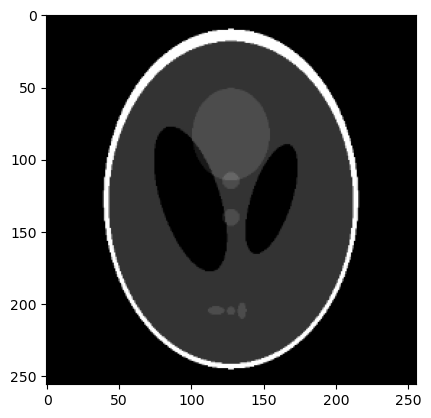

In [5]:
example = 'shepp_logan' # possible choices: 'shepp_logan', 'astronaut'

if example == 'shepp_logan':
    image = resize(shepp_logan_phantom(), (256, 256), anti_aliasing=True)
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/shepp_logan_phantom.png', img_as_uint(image))
if example == 'astronaut':
    image = resize(rgb2gray(astronaut()), (512, 512), anti_aliasing=True)
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/astronaut.png', img_as_uint(image))

In [6]:
print(image.shape)

(256, 256)


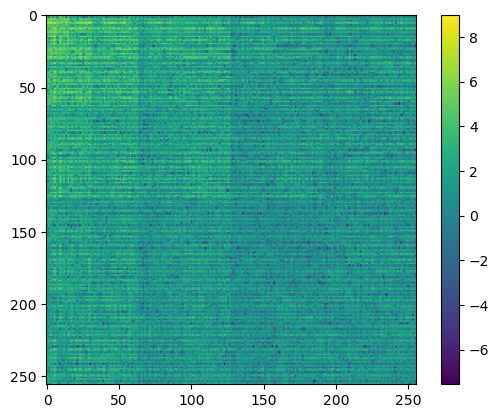

In [7]:
H = FWHT()
hadamard_image = H @ image.flatten()
visual_shift = 0.1/sqrt(image.shape[0]*image.shape[1])
imshow(log(visual_shift + abs(hadamard_image.reshape(image.shape))))
colorbar()
draw();

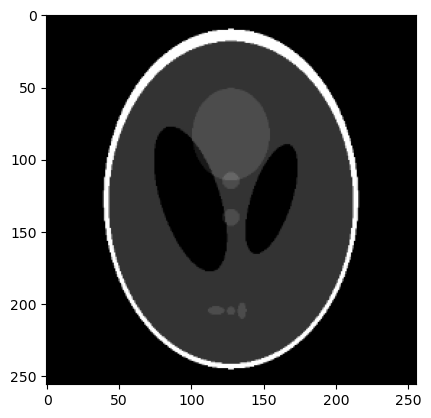

In [8]:
test = H.T @ hadamard_image
imshow(test.reshape(image.shape), cmap='gray');

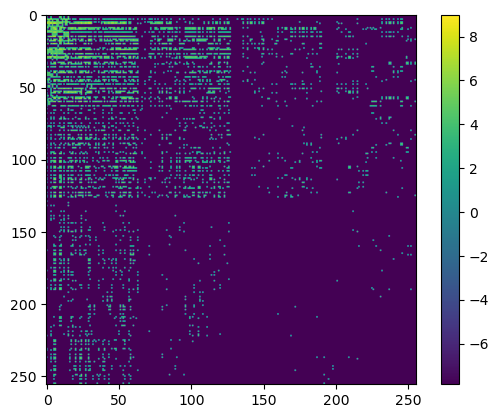

In [9]:
if example == 'shepp_logan':
    N = 4713  # Set N to the desired number of largest coefficients
else:
    N = 16787  # Set N to the desired number of largest coefficients

# Flatten the image and get the absolute values of the coefficients
abs_coefficients = abs(hadamard_image.flatten())

# Find the indices of the N largest coefficients
largest_indices = abs_coefficients.argsort()[-N:]

# Set all coefficients to zero except for the largest N
hadamard_image_filtered = zeros_like(hadamard_image.flatten())
hadamard_image_filtered[largest_indices] = hadamard_image.flatten()[largest_indices]

imshow(log(visual_shift + abs(hadamard_image_filtered.reshape(image.shape))))
colorbar()
draw();

4713 4713


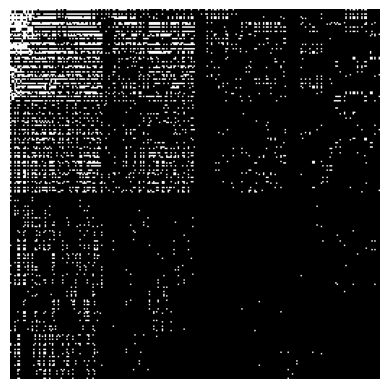

In [10]:
mask = abs(hadamard_image_filtered.reshape(image.shape)) > 0
imshow(mask, cmap='gray');
print(mask.sum(), N)
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_largest_coefficients_mask.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_largest_coefficients_mask.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

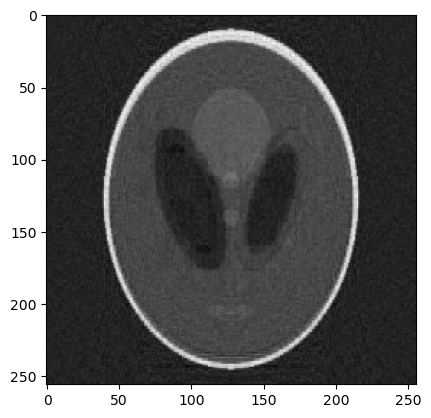

In [11]:
# Apply H.T to the filtered coefficients
test2 = (H.T @ hadamard_image_filtered).reshape(image.shape)

# Visualize the result
imshow(test2, cmap='gray');

# Learning the optimal sampling pattern

In [12]:
if example == 'shepp_logan':
    threshold = 3
if example == 'astronaut':
    threshold = 15

G = Difference_Gradient(image.shape)
finite_difference_image = G @ image
step_sizes = [1, 1/9]
proximal_map = lambda argument : argument - l2ball_projection(argument, axis=2)

l1_proximal_map = lambda argument : soft_thresholding(argument, threshold*step_sizes[1])
identity_proximal_map = lambda argument : argument
proximal_maps = [l1_proximal_map, identity_proximal_map]
bregman_gradient_1_new = lambda arguments: H @ (H.T @ arguments[0] - G.T @ arguments[1])
bregman_gradient_2_new = lambda arguments: G @ (G.T @ arguments[1] - H.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
gradients = [bregman_gradient_1_new, bregman_gradient_2_new]

In [13]:
no_of_iterations = 2500
step_sizes = [1, 1/9]
palm_arguments = [zeros(image.shape), zeros((image.shape[0], \
                                image.shape[1], 2))]                
palm_arguments, norm_list = PALM(gradients, proximal_maps, palm_arguments, step_sizes, \
                            no_of_iterations, print_output=100)                      

/Users/martinbenning/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Research/Projects/Source conditions/source-conditions/source-condition-main/proximal_maps.py:27: RuntimeWarning: invalid value encountered in divide
  output = argument/abs(argument) * (abs(argument) - threshold).clip(0)


Iteration 100/2500, sensitivity = 0.00953622081224751.
Iteration 200/2500, sensitivity = 0.004799484124177432.
Iteration 300/2500, sensitivity = 0.003093173441346714.
Iteration 400/2500, sensitivity = 0.0022289199300777446.
Iteration 500/2500, sensitivity = 0.0017268882092127632.
Iteration 600/2500, sensitivity = 0.0014113073732753556.
Iteration 700/2500, sensitivity = 0.0012022767049577083.
Iteration 800/2500, sensitivity = 0.0010402362802406347.
Iteration 900/2500, sensitivity = 0.0009212609652047849.
Iteration 1000/2500, sensitivity = 0.0008250897294483889.
Iteration 1100/2500, sensitivity = 0.0007567293049129077.
Iteration 1200/2500, sensitivity = 0.0006852449911122504.
Iteration 1300/2500, sensitivity = 0.0006209529287226382.
Iteration 1400/2500, sensitivity = 0.0005729041138549715.
Iteration 1500/2500, sensitivity = 0.0005266725206101596.
Iteration 1600/2500, sensitivity = 0.00048823877117375896.
Iteration 1700/2500, sensitivity = 0.00045220198754159847.
Iteration 1800/2500, sens

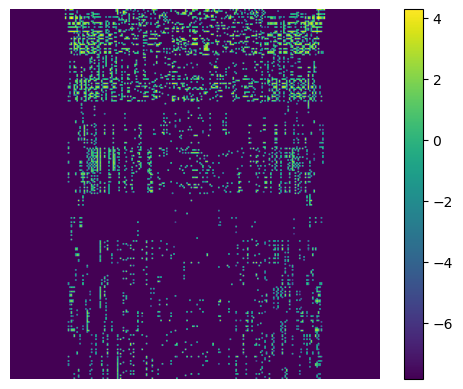

In [14]:
imshow(log(visual_shift + abs(palm_arguments[0])))
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

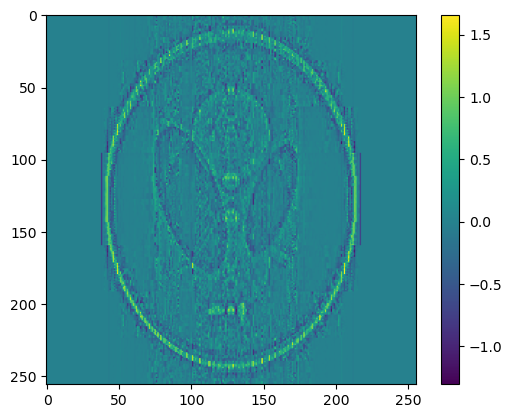

In [15]:
imshow(H.T @ palm_arguments[0])
colorbar();

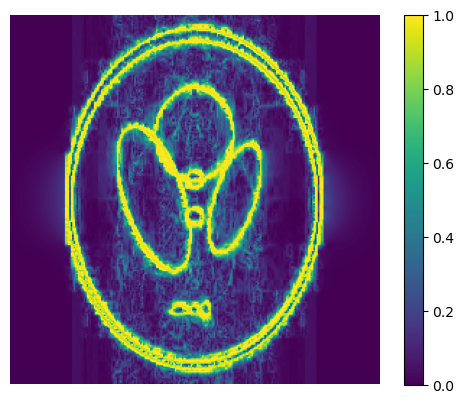

In [16]:
imshow(sqrt(palm_arguments[1][:, :, 0] ** 2 + palm_arguments[1][:, :, 1] ** 2), vmin=0, vmax=1)
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc_subgradient.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc_subgradient.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

900.060886430036
4713 4713


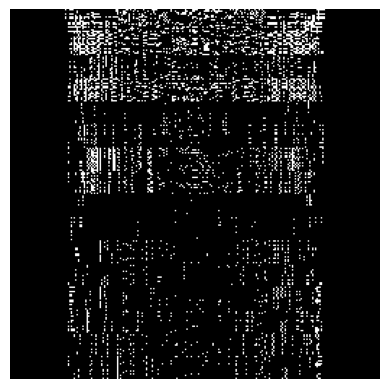

In [17]:
new_source_condition_element = palm_arguments[0]
print(norm(new_source_condition_element.reshape(-1)))
abs_sc_elem = abs(new_source_condition_element)
new_mask = abs_sc_elem > 0
imshow(new_mask, cmap='gray');
print(new_mask.sum(), N)
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_mask.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_mask.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

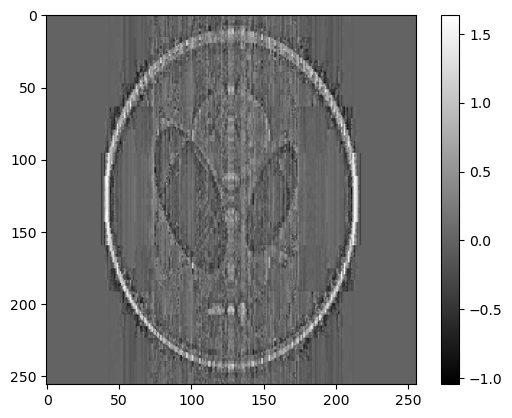

In [18]:
H_new = FWHT_Subsampling(new_mask)
alpha = 0.5
new_data = alpha * palm_arguments[0] + H_new @ image
imshow(H_new.T @ new_data, cmap='gray')
colorbar();

In [19]:
def alternating_minimisation(argument1, argument2, gradient1, gradient2, step_sizes, \
                                no_of_iterations=1000, print_output=10000):
    gradient_norm = []
    for counter in range(no_of_iterations):
        gradient_1 = gradient1([argument1, argument2])
        argument1 -= step_sizes[0] * gradient_1
        gradient_2 = gradient2([argument1, argument2])
        argument2 -= step_sizes[1] * gradient_2
        gradient_norm.append(1/2*(norm(gradient_1) + norm(gradient_2)))
        counter += 1
        if counter % print_output == 0:
            print("Iteration no. {i}/{m}, gradient norm = {g}.".format(i = counter, \
                    m=no_of_iterations, g=gradient_norm[-1]))
    return argument1, argument2, gradient_norm

In [20]:
step_sizes = [1, 1/9]
new_bregman_gradient_1 = lambda arguments: H_new @ (H_new.T @ arguments[0] - G.T @ arguments[1])
new_bregman_gradient_2 = lambda arguments: G @ (G.T @ arguments[1] - H_new.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
no_of_iterations = 2500
new_argument1, new_argument2, gradient_norm = alternating_minimisation(palm_arguments[0], \
                                        palm_arguments[1], new_bregman_gradient_1, \
                                        new_bregman_gradient_2, step_sizes, no_of_iterations, \
                                        print_output=100)

Iteration no. 100/2500, gradient norm = 0.7448221662039263.
Iteration no. 200/2500, gradient norm = 0.45371324586740847.
Iteration no. 300/2500, gradient norm = 0.3354769038764387.
Iteration no. 400/2500, gradient norm = 0.27157548198595177.
Iteration no. 500/2500, gradient norm = 0.23112744829722962.
Iteration no. 600/2500, gradient norm = 0.20263003125556336.
Iteration no. 700/2500, gradient norm = 0.18206721892747177.
Iteration no. 800/2500, gradient norm = 0.16586617587412714.
Iteration no. 900/2500, gradient norm = 0.15292666862265275.
Iteration no. 1000/2500, gradient norm = 0.14198675731575033.
Iteration no. 1100/2500, gradient norm = 0.13292202325488703.
Iteration no. 1200/2500, gradient norm = 0.12532551882098647.
Iteration no. 1300/2500, gradient norm = 0.11853358293384872.
Iteration no. 1400/2500, gradient norm = 0.11255867598851368.
Iteration no. 1500/2500, gradient norm = 0.10732294312530363.
Iteration no. 1600/2500, gradient norm = 0.10265690459537508.
Iteration no. 1700/

1183.9109946289793


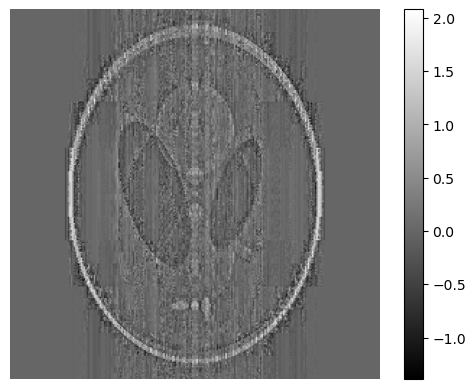

In [21]:
print(norm(new_argument1.reshape(-1)))
new_data = alpha * new_argument1 + H_new @ image
imshow(H_new.T @ new_data, cmap='gray')
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_rc_data_backprojection.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_rc_data_backprojection.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [22]:
step_sizes = [1/8, 1]
primal_proximal_map = lambda argument : subsampled_fourier_prox(argument, new_mask, H, new_data, \
                                            step_sizes[0]/alpha)
dual_proximal_map = lambda argument : l2ball_projection(argument, axis=2)
proximal_maps = [primal_proximal_map, dual_proximal_map]    
initial_arguments = [zeros_like(image), zeros_like(palm_arguments[1])]
max_no_of_iterations=2500
tolerance=1e-6
print_output=100
new_arguments, norm_list = PDHG(G, proximal_maps, initial_arguments, step_sizes, \
                            max_no_of_iterations, print_output, tolerance)

Iteration 100/2500, sensitivity = 0.014660104018944301.
Iteration 200/2500, sensitivity = 0.005956976994507763.
Iteration 300/2500, sensitivity = 0.00337549435177278.
Iteration 400/2500, sensitivity = 0.0023493460166603966.
Iteration 500/2500, sensitivity = 0.0018336695218280983.
Iteration 600/2500, sensitivity = 0.0014444627528624509.
Iteration 700/2500, sensitivity = 0.0011696314319562377.
Iteration 800/2500, sensitivity = 0.0010083200507117979.
Iteration 900/2500, sensitivity = 0.0007376251390442224.
Iteration 1000/2500, sensitivity = 0.0006866175948615615.
Iteration 1100/2500, sensitivity = 0.00048028301011129014.
Iteration 1200/2500, sensitivity = 0.0004577681426953295.
Iteration 1300/2500, sensitivity = 0.0003757679525460796.
Iteration 1400/2500, sensitivity = 0.0003405624830676325.
Iteration 1500/2500, sensitivity = 0.0002560400302412762.
Iteration 1600/2500, sensitivity = 0.00024969945149572734.
Iteration 1700/2500, sensitivity = 0.00020955865381767254.
Iteration 1800/2500, sen

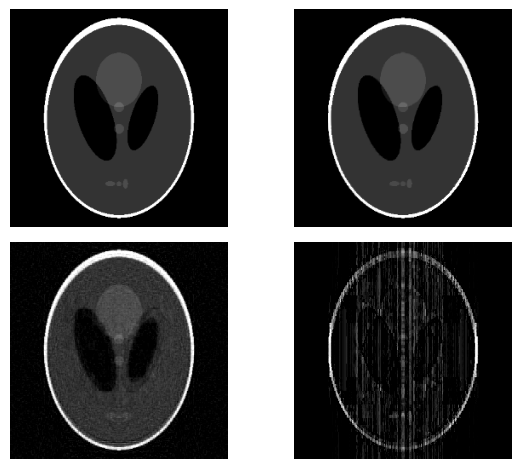

In [23]:
test3 = H_new.T @ (H_new @ image)
subplot(2, 2, 1)
imshow(image, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(test3, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

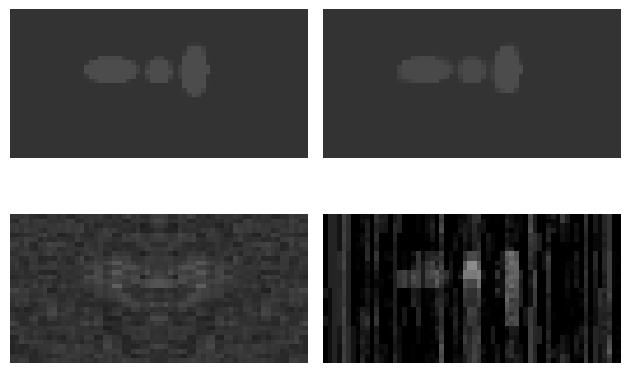

In [24]:
if example == 'shepp_logan':
    window = (slice(192, 224), slice(96, 160))
if example == 'astronaut':
    window = (slice(50, 150), slice(200, 300))
subplot(2, 2, 1)
imshow(image[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0][window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(test3[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)